In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Load all trips and filter by SOC change > 5%
trip_files = sorted(glob('BMW_i3_Dataset/Trip*.csv'))
print(f"Total trip files: {len(trip_files)}")

valid_trips = []
for trip_file in trip_files:
    df = pd.read_csv(trip_file, sep=';', encoding='latin-1')
    soc_change = df['SoC [%]'].iloc[0] - df['SoC [%]'].iloc[-1]
    
    if soc_change > 5:  # Only trips with >5% SOC change
        trip_name = trip_file.split('\\')[-1]
        valid_trips.append((trip_name, df, soc_change))

print(f"Valid trips (SOC change > 5%): {len(valid_trips)}")
for name, _, change in valid_trips[:10]:
    print(f"  {name}: {change:.1f}% change")

Total trip files: 70
Valid trips (SOC change > 5%): 39
  TripA01.csv: 5.4% change
  TripA02.csv: 13.0% change
  TripA03.csv: 8.4% change
  TripA04.csv: 8.4% change
  TripA05.csv: 6.5% change
  TripA06.csv: 21.7% change
  TripA07.csv: 29.2% change
  TripA08.csv: 10.5% change
  TripA09.csv: 6.1% change
  TripA10.csv: 8.7% change


In [16]:
# Combine all valid trips and remove idle segments (velocity=0 for >30s)
combined_data = []

for trip_name, df, _ in valid_trips:
    # Check column names (handle encoding issues)
    velocity_col = [col for col in df.columns if 'Velocity' in col][0]
    
    # Remove rows where velocity is 0 (parked/idle)
    df_moving = df[df[velocity_col] > 0.5].copy()
    
    if len(df_moving) > 100:  # Keep only if enough data points
        df_moving['Trip'] = trip_name
        combined_data.append(df_moving)

data = pd.concat(combined_data, ignore_index=True)
print(f"Total samples after filtering: {len(data):,}")

# Get actual column name for SoC
soc_col = [col for col in data.columns if 'SoC' in col and 'displayed' not in col and 'min' not in col and 'max' not in col][0]
print(f"SOC range: {data[soc_col].min():.1f}% to {data[soc_col].max():.1f}%")

Total samples after filtering: 558,836
SOC range: 34.2% to 88.5%


In [17]:
# Feature engineering - get actual column names
col_map = {}
for pattern in ['Battery Voltage', 'Battery Current', 'Battery Temperature', 'Ambient Temperature', 
                'Velocity', 'Elevation', 'SoC']:
    matching = [col for col in data.columns if pattern in col and 'displayed' not in col and 'min' not in col and 'max' not in col]
    if matching:
        col_map[pattern] = matching[0]

print("Column mapping:")
for k, v in col_map.items():
    print(f"  {k} -> {v}")

# Feature engineering
data['Power [W]'] = data[col_map['Battery Voltage']] * data[col_map['Battery Current']]
data['Velocity_squared'] = data[col_map['Velocity']] ** 2
data['Temp_diff'] = data[col_map['Battery Temperature']] - data[col_map['Ambient Temperature']]

# Select features - only use columns that exist and have no NaN
feature_cols = [
    col_map['Battery Voltage'],
    col_map['Battery Current'],
    col_map['Battery Temperature'],
    col_map['Ambient Temperature'],
    col_map['Velocity'],
    col_map['Elevation'],
    'Power [W]',
    'Velocity_squared',
    'Temp_diff'
]

# Drop any rows with NaN in feature columns or target
feature_data = data[feature_cols + [col_map['SoC']]].copy()
print(f"\nSamples before dropna: {len(feature_data):,}")
feature_data = feature_data.dropna()
print(f"Samples after dropna: {len(feature_data):,}")

X = feature_data[feature_cols].values
y = feature_data[col_map['SoC']].values

print(f"\nFeatures: {len(feature_cols)}")
print(f"Final samples: {len(X):,}")

Column mapping:
  Battery Voltage -> Battery Voltage [V]
  Battery Current -> Battery Current [A]
  Battery Temperature -> Battery Temperature [°C]
  Ambient Temperature -> Ambient Temperature [°C]
  Velocity -> Velocity [km/h]
  Elevation -> Elevation [m]
  SoC -> SoC [%]

Samples before dropna: 558,836
Samples after dropna: 543,939

Features: 9
Final samples: 543,939


In [18]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")
print(f"\nTrain SOC range: {y_train.min():.1f}% to {y_train.max():.1f}%")
print(f"Test SOC range: {y_test.min():.1f}% to {y_test.max():.1f}%")

Training samples: 435,151
Testing samples: 108,788

Train SOC range: 34.2% to 88.5%
Test SOC range: 34.2% to 88.5%


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled")
print(f"Mean after scaling: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Std after scaling: {X_train_scaled.std(axis=0).round(3)}")

Features scaled
Mean after scaling: [ 0. -0.  0. -0.  0.  0. -0. -0.  0.]
Std after scaling: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=10, 
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Random Forest Results:")
print(f"  Train R²: {train_r2:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}%")
print(f"  Test MAE: {test_mae:.4f}%")

Random Forest Results:
  Train R²: 0.9998
  Test R²: 0.9995
  Test RMSE: 0.2715%
  Test MAE: 0.0921%


In [21]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      min_samples_split=10, random_state=42)
gb_model.fit(X_train_scaled, y_train)

y_pred_gb_train = gb_model.predict(X_train_scaled)
y_pred_gb_test = gb_model.predict(X_test_scaled)

gb_train_r2 = r2_score(y_train, y_pred_gb_train)
gb_test_r2 = r2_score(y_test, y_pred_gb_test)
gb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
gb_test_mae = mean_absolute_error(y_test, y_pred_gb_test)

print("Gradient Boosting Results:")
print(f"  Train R²: {gb_train_r2:.4f}")
print(f"  Test R²: {gb_test_r2:.4f}")
print(f"  Test RMSE: {gb_test_rmse:.4f}%")
print(f"  Test MAE: {gb_test_mae:.4f}%")

Gradient Boosting Results:
  Train R²: 0.9976
  Test R²: 0.9973
  Test RMSE: 0.6355%
  Test MAE: 0.4573%


In [22]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_model.feature_importances_,
    'GB_Importance': gb_model.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                    Feature  RF_Importance  GB_Importance
0       Battery Voltage [V]       0.729525       0.733273
6                 Power [W]       0.122431       0.132793
2  Battery Temperature [°C]       0.047625       0.047225
5             Elevation [m]       0.029958       0.023331
1       Battery Current [A]       0.024013       0.022551
8                 Temp_diff       0.018626       0.013055
3  Ambient Temperature [°C]       0.011356       0.011353
4           Velocity [km/h]       0.008259       0.007965
7          Velocity_squared       0.008206       0.008453


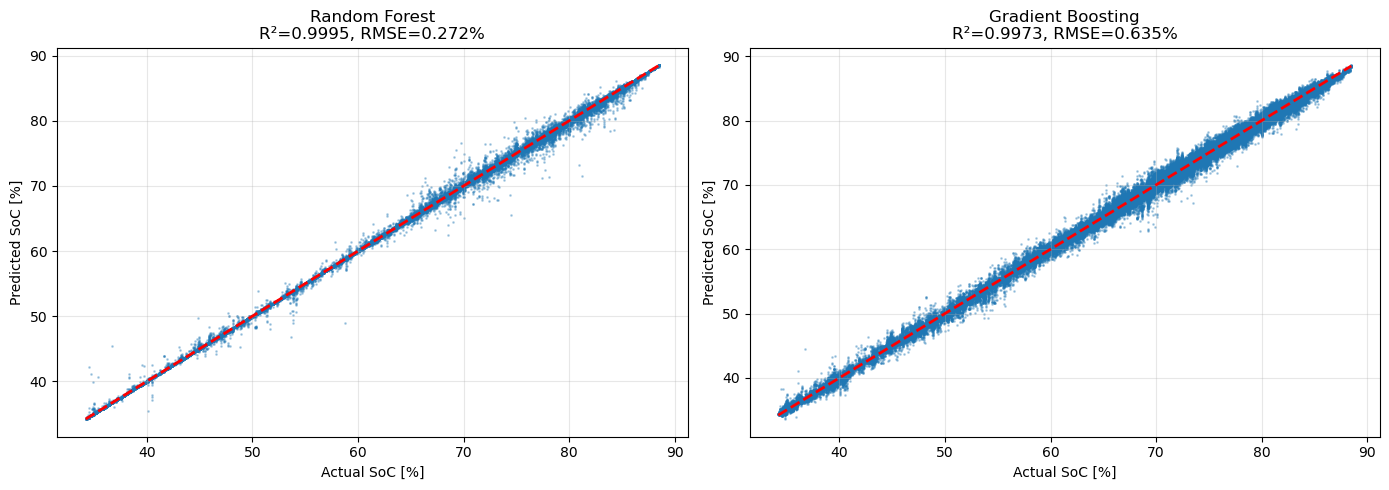

In [23]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].scatter(y_test, y_pred_test, alpha=0.3, s=1)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual SoC [%]')
axes[0].set_ylabel('Predicted SoC [%]')
axes[0].set_title(f'Random Forest\nR²={test_r2:.4f}, RMSE={test_rmse:.3f}%')
axes[0].grid(True, alpha=0.3)

# Gradient Boosting
axes[1].scatter(y_test, y_pred_gb_test, alpha=0.3, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual SoC [%]')
axes[1].set_ylabel('Predicted SoC [%]')
axes[1].set_title(f'Gradient Boosting\nR²={gb_test_r2:.4f}, RMSE={gb_test_rmse:.3f}%')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

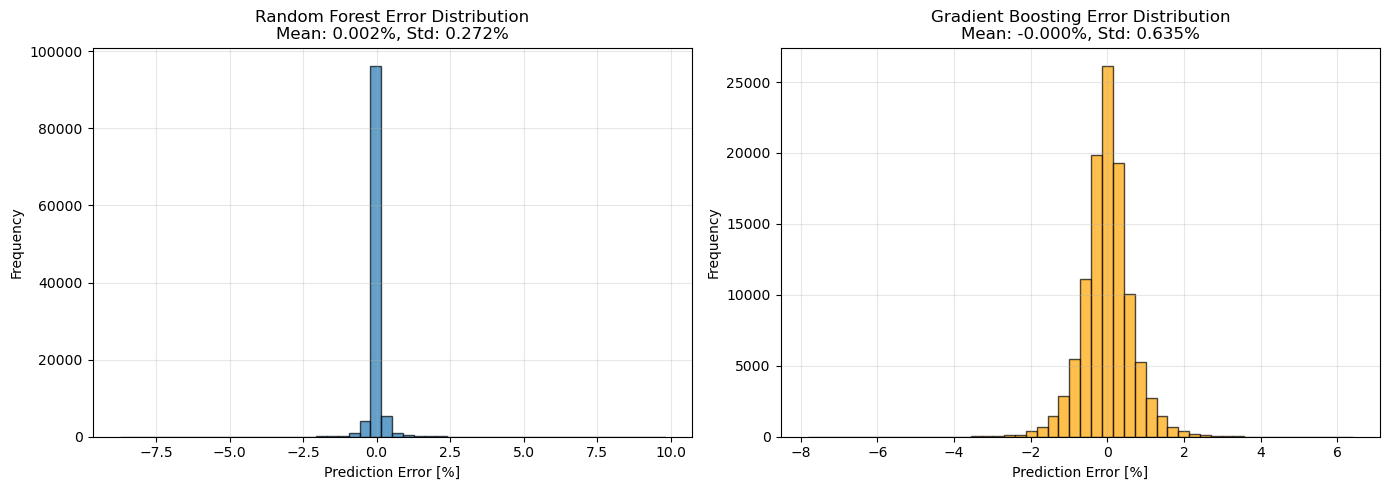

In [26]:
# Error distribution
errors_rf = y_test - y_pred_test
errors_gb = y_test - y_pred_gb_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors_rf, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Prediction Error [%]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Random Forest Error Distribution\nMean: {errors_rf.mean():.3f}%, Std: {errors_rf.std():.3f}%')
axes[0].grid(True, alpha=0.3)

axes[1].hist(errors_gb, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Prediction Error [%]')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Gradient Boosting Error Distribution\nMean: {errors_gb.mean():.3f}%, Std: {errors_gb.std():.3f}%')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Summary
print("="*70)
print("SOC PREDICTION MODEL SUMMARY")
print("="*70)
print(f"\nDataset: {len(data):,} samples from {len(valid_trips)} trips")
print(f"Features: {len(feature_cols)}")
print(f"\nBest Model: {'Random Forest' if test_r2 > gb_test_r2 else 'Gradient Boosting'}")
print(f"  R² Score: {max(test_r2, gb_test_r2):.4f}")
print(f"  RMSE: {min(test_rmse, gb_test_rmse):.4f}%")
print(f"  MAE: {min(test_mae, gb_test_mae):.4f}%")
print(f"\nTop 3 Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {row['Feature']}: {row['RF_Importance']:.3f}")
print("="*70)

SOC PREDICTION MODEL SUMMARY

Dataset: 558,836 samples from 39 trips
Features: 9

Best Model: Random Forest
  R² Score: 0.9995
  RMSE: 0.2715%
  MAE: 0.0921%

Top 3 Important Features:
  Battery Voltage [V]: 0.730
  Power [W]: 0.122
  Battery Temperature [°C]: 0.048
